In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import scipy.spatial
import json
from matplotlib import cm as CM
import time
# from image import *
# from model import CSRNet
# import torch
%matplotlib inline

In [2]:
#set the root to the Shanghai dataset you download
root = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\UCF_50_CC_GAK'

imgs_dir = os.path.join(root, 'img')
dens_dir = os.path.join(root, 'den')
gt_dir = os.path.join(root, 'dots')

folds_nums = ['1', '2', '3', '4', '5']

In [3]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density1(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)  # 4, because first is self

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1  # 1/3 * 0.3 = 0.1
        else:
            print("Does this happen?")
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [4]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density2(gt):
#     print(f'shape: {gt.shape}, count: {gt.sum()}')
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)  # 4, because first is self

#     print('generate density...')
    for i, pt in enumerate(pts):
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1  # 1/3 * 0.3 = 0.1
        else:
            print("Does this happen?")
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
            
        gaus_dist = np.round(sigma * 4).astype(int)
        gaus_dims = 2 * gaus_dist + 1
        gaus_centre = gaus_dist
        
        pt2d = np.zeros((gaus_dims, gaus_dims), dtype=np.float32)
        pt2d[gaus_centre, gaus_centre] = 1.
        
        distr = scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        
        y = pt[0]
        x = pt[1]
        
        lower_x = max(x - gaus_dist, 0)
        upper_x = min(x + gaus_dist + 1,  gt.shape[0])
        lower_y = max(y - gaus_dist, 0)
        upper_y = min(y + gaus_dist + 1,  gt.shape[1])     
        
        lower_x_gaus = max(-(x - gaus_dist), 0)
        upper_x_gaus = gaus_dims - max((x + gaus_dist + 1) - gt.shape[0], 0)
        lower_y_gaus = max(-(y - gaus_dist), 0)
        upper_y_gaus = gaus_dims - max((y + gaus_dist + 1) - gt.shape[1], 0)
        
        density[lower_x:upper_x, lower_y:upper_y] += distr[lower_x_gaus:upper_x_gaus, lower_y_gaus:upper_y_gaus]
    return density

In [7]:
start_time = time.time()
for fold_num in folds_nums:
    imgs_fold_dir = os.path.join(imgs_dir, fold_num)
    dens_fold_dir = os.path.join(dens_dir, fold_num)
    for img_name in os.listdir(imgs_fold_dir):
        
        
        full_img_path = os.path.join(imgs_fold_dir, img_name)
        full_den_path = full_img_path.replace('img', 'den').replace('.jpg', '.h5')
        full_dots_path = os.path.join(gt_dir, img_name[:-4] + '_ann.mat')
        
        mat = io.loadmat(full_dots_path)
        img = plt.imread(full_img_path)
        k = np.zeros((img.shape[0],img.shape[1]))
        
        gt = mat['annPoints']
        
        print(f'img {counter}, count: {len(gt)}')
        for i in range(0,len(gt)):
            if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
                k[int(gt[i][1]),int(gt[i][0])]=1
#         k_old = gaussian_filter_density1(k)  # Pleb code
        k = gaussian_filter_density2(k)
        with h5py.File(full_den_path, 'w') as hf:
                hf['density'] = k 
                
        counter += 1

    
        

img 51, count: 730


In [ ]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

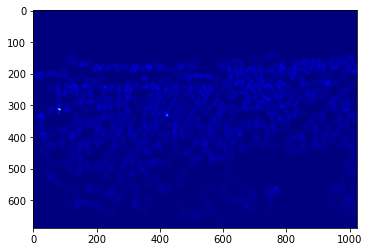

In [258]:
groundtruth = k1
plt.imshow(groundtruth,cmap=CM.jet)

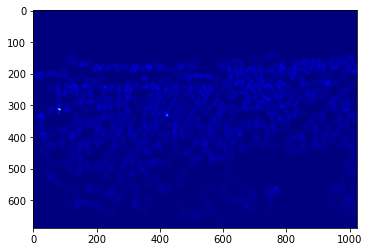

In [259]:
groundtruth = k2
plt.imshow(groundtruth,cmap=CM.jet)

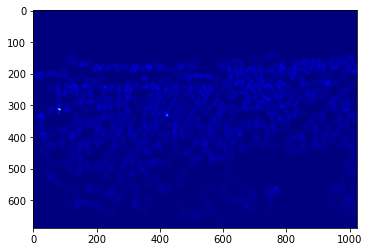

In [7]:
gt_file = h5py.File('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\UCF_50_CC_GAK\\den\\1\\13.h5','r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [54]:
np.sum(groundtruth)# don't mind this slight variation

727.64075

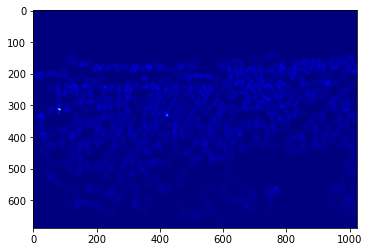

In [9]:
import pandas as pd

my_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\UCF_50_CC_GAK\\den\\1\\13.csv'
den = pd.read_csv(my_path, sep=',',header=None).values
den = den.astype(np.float32, copy=False)
plt.imshow(den,cmap=CM.jet)

In [10]:
print(den.sum())

727.6409
